Experiments:
1. Does enforcing a sampling-quality penalty (GAN) impart a distribution over the latent space? Does the KL-divergence of encoded points implicitly get satisfied with the GAN penalty?
2. What happens when we encode and decode training points without any reconstruction training?

In [1]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
from torch.utils.data import TensorDataset, DataLoader

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import helpers
# im re-naming utils to helpers....
# Disentanglement Metrics:
from metrics.dci import dci
from metrics.sap import sap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()


floor hue: 10 values linearly spaced in [0, 1]
wall hue: 10 values linearly spaced in [0, 1]
object hue: 10 values linearly spaced in [0, 1]
scale: 8 values linearly spaced in [0, 1]
shape: 4 values in [0, 1, 2, 3]
orientation: 15 values linearly spaced in [-30, 30]

In [2]:
img_size = 64 # can use this to mofidy data size to fit this model
n_epochs = 10 #50? depends on max_sampels
print_stride = n_epochs // 10
max_samples = 8000 #80k, 10k is fine
bs = 32 # 64
alpha = 1
beta = 1

dataset = tfds.load('shapes3d', split = 'train')
print(type(dataset))
builder = tfds.builder('shapes3d')

ds, info = tfds.load('shapes3d', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)
ds_numpy = tfds.as_numpy(ds)
i = 0
print('past loading, onto forming')
images, codes = [], []

for tup in ds_numpy:
    if i >= max_samples:
        break
    #print(tup)
    img = 2*((torch.Tensor(list(tup.values())[0]) / 255) - .5)
    del tup['image']
    vals = list(tup.values())
    #print(vals)
    indicies = [6, 8, 9, 10, 11] #Should be all but obj. hue, but not sure that it is
    #indicies = [7, 8, 9, 10, 11] #Should be ___?
    selected_codes = []
    for index in indicies:
        selected_codes.append(vals[index])
    
    vals = torch.Tensor(selected_codes)

    images.append(img)
    codes.append(vals)
    i+=1



<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
past loading, onto forming


In [3]:
train_codes = torch.stack(codes)
print(train_codes.shape)
print(train_codes)
print(train_codes.min(0, keepdim = True)[0])
a = train_codes - train_codes.min(0, keepdim = True)[0]
print(a)
b = a / a.max(0, keepdim = True)[0]
print(b)

torch.Size([8000, 5])
tensor([[  0.0000, -12.8571,   0.8214,   1.0000,   0.3000],
        [  0.4000,   0.0000,   1.1786,   0.0000,   0.2000],
        [  0.9000,  12.8571,   0.7500,   1.0000,   0.8000],
        ...,
        [  0.9000,   4.2857,   1.1071,   2.0000,   0.3000],
        [  0.7000,   0.0000,   0.7500,   2.0000,   0.4000],
        [  0.1000,   4.2857,   1.2500,   1.0000,   0.3000]])
tensor([[  0.0000, -30.0000,   0.7500,   0.0000,   0.0000]])
tensor([[ 0.0000, 17.1429,  0.0714,  1.0000,  0.3000],
        [ 0.4000, 30.0000,  0.4286,  0.0000,  0.2000],
        [ 0.9000, 42.8571,  0.0000,  1.0000,  0.8000],
        ...,
        [ 0.9000, 34.2857,  0.3571,  2.0000,  0.3000],
        [ 0.7000, 30.0000,  0.0000,  2.0000,  0.4000],
        [ 0.1000, 34.2857,  0.5000,  1.0000,  0.3000]])
tensor([[0.0000, 0.2857, 0.1429, 0.3333, 0.3333],
        [0.4444, 0.5000, 0.8571, 0.0000, 0.2222],
        [1.0000, 0.7143, 0.0000, 0.3333, 0.8889],
        ...,
        [1.0000, 0.5714, 0.7143, 0.6

tensor(-1.) tensor(1.)


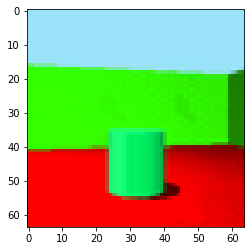

In [4]:
train_images = torch.stack(images).permute(0,3,1,2)
train_codes = torch.stack(codes)

train_codes -= train_codes.min(0, keepdim=True)[0]
train_codes /= train_codes.max(0, keepdim=True)[0]

print(torch.min(train_images[0]), torch.max(train_images[0]))
plt.imshow(0.5*(train_images[0].permute(1,2,0) + 1))

In [5]:
print(train_codes)

for row in train_codes:
    print(row)
    break
c_dim = train_codes.shape[1]
print(c_dim)
# not really sure what to do as far as one-hotting goes.
# ill just try "shape" as a weird continuous for now

print('here is the first code for the above image: ')
print(train_codes[0])

tensor([[0.0000, 0.2857, 0.1429, 0.3333, 0.3333],
        [0.4444, 0.5000, 0.8571, 0.0000, 0.2222],
        [1.0000, 0.7143, 0.0000, 0.3333, 0.8889],
        ...,
        [1.0000, 0.5714, 0.7143, 0.6667, 0.3333],
        [0.7778, 0.5000, 0.0000, 0.6667, 0.4444],
        [0.1111, 0.5714, 1.0000, 0.3333, 0.3333]])
tensor([0.0000, 0.2857, 0.1429, 0.3333, 0.3333])
5
here is the first code for the above image: 
tensor([0.0000, 0.2857, 0.1429, 0.3333, 0.3333])


In [6]:
img_size // 1.08

59.0

tensor(0.) tensor(1.)


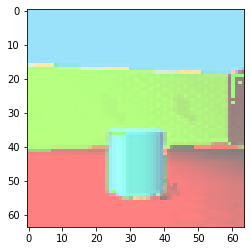

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.RandomRotation(20),
    #transforms.RandomAffine(),
    #transforms.RandomCrop(img_size // 1.1), #crop down to __ size. decent model doesnt use this
])


class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    
train_dataset_normal = CustomTensorDataset(tensors=(train_images, train_codes), transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset_normal, 
                                           batch_size=bs, 
                                           drop_last = True,
                                           pin_memory = True # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
                                           #num_workers = 0
                                          ) # Just trying > 0, someone says 4*num_gpu is good?
plt.imshow(0.5*(next(iter(train_loader))[0][0].permute(1,2,0) + 1))

print(torch.min(next(iter(train_loader))[0][0]), torch.max(next(iter(train_loader))[0][0]))

In [8]:
def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

In [9]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(1024)
        
        #self.conv5v = nn.Conv2d(1024, v_dim, 4, 1, 0) # Output: (bs, c_dim, 1, 1)
        #self.conv5c = nn.Conv2d(1024, c_dim, 4, 1, 0) # Output, same as above: but this one to condition-space
        self.conv5 = nn.Conv2d(1024, z_dim, 4, 1, 0) # Output, same as above: but this one to condition-space
        
        ## Decoding:
        # need seperate v, c layers here
        #self.deconv1v = nn.ConvTranspose2d(v_dim, 1024, 4, 1, 0, bias = False) # Not sure how this looks
        #self.deconv1c = nn.ConvTranspose2d(c_dim, 1024, 4, 1, 0, bias = False) # Input: (bs, cdim+v_dim, 1, 1)
        self.deconv1 = nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0, bias = False) # Input: (bs, cdim+v_dim, 1, 1)
        
        # self.deconv1 or 2 = nn.ConvTranspose2d2(1024+1024, 4, 1, 0)?
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias = False)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 3, 4, 2, 1)
    
    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
            
    def encode(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        
        #v = torch.sigmoid(self.conv5v(x)) # Variance-space unif~[0,1]
        #c = torch.sigmoid(self.conv5c(x)) # this is softmax for CLASSIFICATION. Shapes3d is not 1-classif..
        z = torch.tanh(self.conv5(x)) # unactivated for RandN
        
        return z
      
    def decode(self, z):
        #print('enter decode, v,c: ', v.shape, c.shape)
        #v = self.deconv1_bn(self.deconv1v(v))
        #c = self.deconv1_bn(self.deconv1c(c))
        x = self.deconv1_bn(self.deconv1(z))
        #print('v, c shapes, ', v.shape, c.shape)
        #x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x)) #changed from -1,1 to 0,1 somehow?
        return x
    

    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
# maybe later
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Discriminator:
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1) # (bs, 3 + , img_size, img_size)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)
        # possible i need to finagle some kind of conv6... not sure
    
    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
      
    def forward(self, x):
        #print(x.shape, c.shape)
        #print(x.shape)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x


In [10]:
def get_codes(bs):
    # I think this might be super slow...
    floor_hues = torch.rand((bs,1))
    #obj_hues = torch.randint(0, 10, (bs,1)) / 10
    orientation = torch.rand((bs,1))
    scale = torch.rand((bs,1))
    shape = torch.rand((bs,1))
    wall_hue = torch.rand((bs,1))
    
    return torch.cat((floor_hues, orientation, scale, shape, wall_hue), dim = 1)

def print_ae_sample():
    with torch.no_grad():
        generated = AE.forward(X).cpu()
        print(torch.min(generated), torch.max(generated))
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        element = generated[i,:].permute(1,2,0)
        plt.imshow(element)
    plt.show()
    
def print_g_sample():
    with torch.no_grad():
        print('below plot is 9 fully-random samples, GAN')
        varis = torch.randn((9, z_dim, 1, 1), device = device) # walk from [0,...,0] to [1,...,1]
        #generated = .5*(AE.decode(varis).cpu() + 1)
        generated = AE.decode(varis).cpu()
        for i in range(9):
            plt.subplot(330 + 1 + i)
            # plot raw pixel data
            element = generated[i,:].permute(1,2,0)
            plt.imshow(element)
        plt.show()
        
def print_KLD():
    # Print and return and KL-Divergence between the latent sample distribution and the validation encodings
    with torch.no_grad():
        tot_loss = 0
        i = 0
        for X, code in train_loader: # change to test_loader eventually
            z = AE.encode(X.to(device))
            loss = kld_loss(z, torch.randn(z.shape, device = device))
            tot_loss -= loss.data.item()
            i += 1
        
    print('Avg KL - randn', tot_loss / i)
    return tot_loss / i

def print_disentanglement_score():
    
    with torch.no_grad():
        tot_loss = 0
        i = 0
        dci_score = 0
        sap_score = 0
        for X, code in train_loader: # change to test_loader eventually
            X, code = X.to(device), code.to(device)
            z = AE.encode(X)
            dci_score += dci(code.cpu(), z.cpu().view(X.shape[0], z_dim))[0]
            sap_score += sap(code.cpu(), z.cpu().view(X.shape[0], z_dim))
            i+=1
            
        
    print('Avg dci: ', dci_score / i)
    print('Avg sap: ', sap_score / i)
    return dci_score/i, sap_score/i
    
    #print(dci(fact_batch.detach().cpu().view(mini_batch, c_dim), code_batch.detach().cpu().view(mini_batch, z_dim))[0])
    ##irs(fact_batch, code_batch)
    #print(sap(fact_batch.detach().cpu().view(mini_batch, c_dim), code_batch.detach().cpu().view(mini_batch, z_dim)))

In [11]:
z_dim = 2

AE = Autoencoder()
AE.weight_init()
AE.to(device)
D = Discriminator()
D.weight_init()
D.to(device)

bce_loss = nn.BCELoss()
mae_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
kld_loss = nn.KLDivLoss(reduction = 'batchmean')

g_learning_rate = .0002
d_learning_rate = .0002

AE_optimizer = optim.Adam(AE.parameters(),
                         lr = g_learning_rate, betas = (0.5, .99))
D_optimizer = optim.Adam(D.parameters(), lr = d_learning_rate, betas = (0.5, .99))

For reference, initialization KLD, dci, sap to compare learned results
Avg KL - randn 0.050808355167508125
Avg dci:  0.5956667400138588
Avg sap:  0.05404721886418464
Epoch 1 - loss_ae (mse): 0.142, loss_D: 3.699, loss_G: 43.688
Below plot is autoencoder reconstruction
tensor(0.0030) tensor(0.9957)


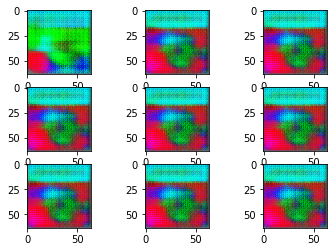

below plot is 9 fully-random samples, GAN


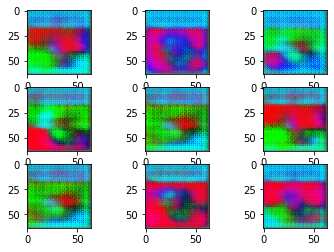

Avg KL - randn 0.17846174109727145
Avg dci:  0.6305339294881194
Avg sap:  0.03378022787435084
Epoch 2 - loss_ae (mse): 0.153, loss_D: 1.099, loss_G: 3.753
Below plot is autoencoder reconstruction
tensor(2.4777e-06) tensor(1.0000)


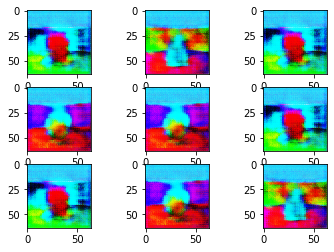

below plot is 9 fully-random samples, GAN


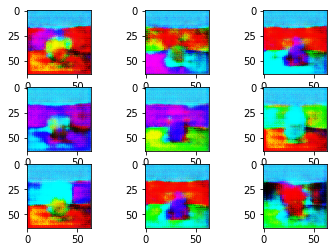

Avg KL - randn -0.07597892514616252
Avg dci:  0.5171284581936095
Avg sap:  0.050421857972427334
Epoch 3 - loss_ae (mse): 0.166, loss_D: 0.794, loss_G: 3.436
Below plot is autoencoder reconstruction
tensor(4.4992e-09) tensor(1.0000)


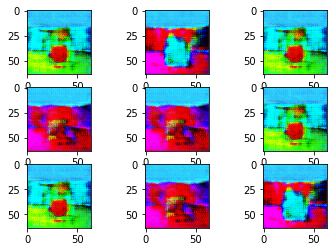

below plot is 9 fully-random samples, GAN


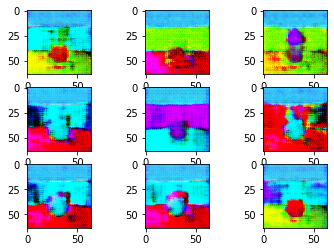

Avg KL - randn -0.06379456355422736
Avg dci:  0.5147634792715448
Avg sap:  0.05099971999779933
Epoch 4 - loss_ae (mse): 0.171, loss_D: 0.646, loss_G: 3.801
Below plot is autoencoder reconstruction
tensor(1.4207e-08) tensor(1.0000)


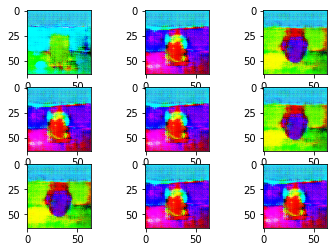

below plot is 9 fully-random samples, GAN


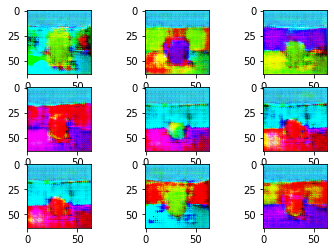

Avg KL - randn -0.22117668794840575
Avg dci:  0.5492304802316746
Avg sap:  0.03092274607310881
Epoch 5 - loss_ae (mse): 0.183, loss_D: 0.492, loss_G: 4.472
Below plot is autoencoder reconstruction
tensor(3.8097e-11) tensor(1.0000)


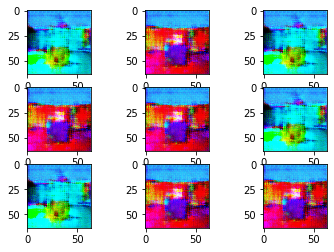

below plot is 9 fully-random samples, GAN


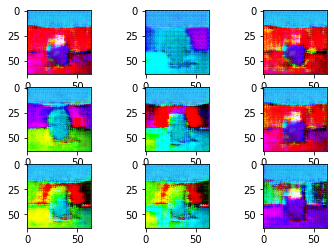

Avg KL - randn 0.10151121010631323
Avg dci:  0.5430797272484387
Avg sap:  0.04023141633855619
Epoch 6 - loss_ae (mse): 0.163, loss_D: 0.426, loss_G: 5.236
Below plot is autoencoder reconstruction
tensor(1.3782e-10) tensor(1.)


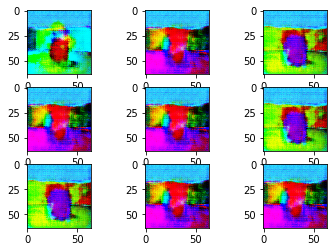

below plot is 9 fully-random samples, GAN


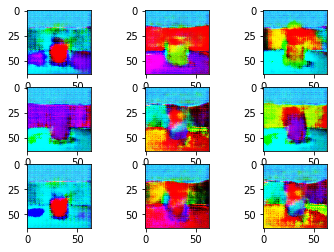

Avg KL - randn 0.12964985429495574
Avg dci:  0.5068221926723978
Avg sap:  0.0407393089891733
Epoch 7 - loss_ae (mse): 0.168, loss_D: 0.344, loss_G: 5.207
Below plot is autoencoder reconstruction
tensor(4.3726e-12) tensor(1.)


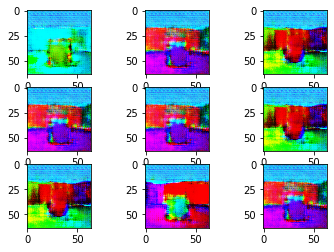

below plot is 9 fully-random samples, GAN


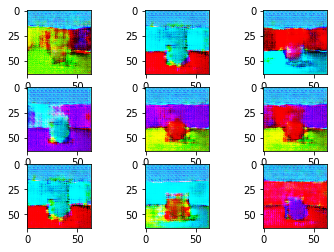

Avg KL - randn 0.07886148499697447
Avg dci:  0.49342349796440677
Avg sap:  0.028660170775015602
Epoch 8 - loss_ae (mse): 0.162, loss_D: 0.308, loss_G: 5.512
Below plot is autoencoder reconstruction
tensor(6.4171e-13) tensor(1.)


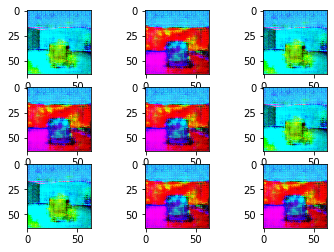

below plot is 9 fully-random samples, GAN


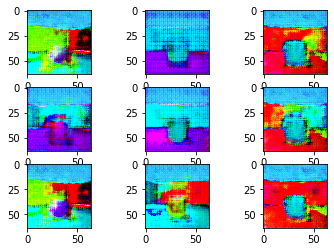

Avg KL - randn 0.12551390984654426
Avg dci:  0.5175032526819607
Avg sap:  0.03585036907083397
Epoch 9 - loss_ae (mse): 0.169, loss_D: 0.343, loss_G: 5.617
Below plot is autoencoder reconstruction
tensor(3.5966e-13) tensor(1.0000)


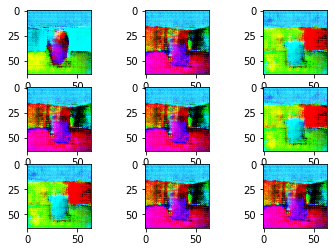

below plot is 9 fully-random samples, GAN


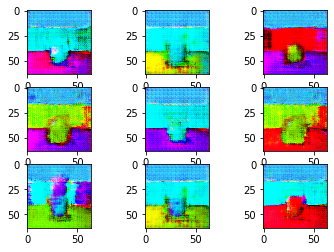

Avg KL - randn 0.17370027684420347
Avg dci:  0.4643902620289155
Avg sap:  0.03827147079277513
Epoch 10 - loss_ae (mse): 0.169, loss_D: 0.232, loss_G: 5.980
Below plot is autoencoder reconstruction
tensor(6.2243e-14) tensor(1.)


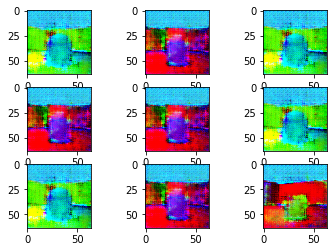

below plot is 9 fully-random samples, GAN


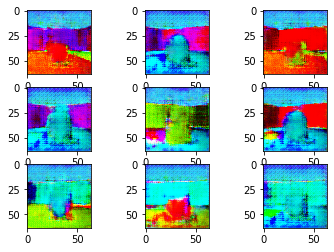

Avg KL - randn 0.1400007067248225
Avg dci:  0.5302831441181679
Avg sap:  0.039278668655337065


In [12]:
AE_loss_tracker = []
D_loss_tracker = []
G_loss_tracker = []

dci_list, sap_list, kld_list = [], [], []

print('For reference, initialization KLD, dci, sap to compare learned results')
print_KLD()
print_disentanglement_score()

for epoch in range(1, n_epochs+1):
    G_losses = []
    D_losses = []
    recon_losses = []
    for X, code in train_loader:
        
        mini_batch = X.size()[0]
        
        #print(torch.min(X), torch.max(X))

        X = X.to(device) #Variable is depreciated
        code = code.to(device)
        rand_z = torch.randn((mini_batch, z_dim), device = device).view(mini_batch, z_dim, 1, 1)
        
        ## Discriminator Training
        for param in D.parameters():
            param.grad = None
            
        y_real = torch.ones((mini_batch,1,1,1), device = device)*1.0 # Sometimes .9, .1
        y_fake = torch.ones((mini_batch,1,1,1), device = device)*0.0 # 
        
        D_real_out = D(X)
        D_real_loss = bce_loss(D_real_out, y_real)

        X_fake = AE.decode(rand_z)
        D_fake_out = D(X_fake)
        D_fake_loss = bce_loss(D_fake_out, y_fake)
        
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        
        # What if this just kicks in a bit later?
        ## Adversarial Loss ("variation-structure loss"?)
        rand_z = torch.randn((mini_batch, z_dim), device = device).view(mini_batch, z_dim, 1, 1)
        #print(rand_v.shape, rand_c.shape)
        X_fake = AE.decode(rand_z) #Do I need to re-roll rand_v, rand_c?
        D_out = D(X_fake)
        y_targ = torch.ones((mini_batch,1,1,1), device = device) #G gets low loss when D returns X_fake near 1
        G_loss = bce_loss(D_out, y_targ)

        ## Autoencoder training
        for param in AE.parameters():
            param.grad = None

        X_hat = AE(X)
        recon_loss = mse_loss(X_hat, X)
        
        ## Loss combination
        model_loss = recon_loss + G_loss

        
        model_loss.backward()
        AE_optimizer.step()

        recon_losses.append(recon_loss.data.item())
        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())

    if epoch % print_stride == 0:
        print('Epoch {} - loss_ae (mse): {:.3f}, loss_D: {:.3f}, loss_G: {:.3f}'.format((epoch),
                                                               torch.mean(torch.FloatTensor(recon_losses)),
                                                               torch.mean(torch.FloatTensor(D_losses)),
                                                               torch.mean(torch.FloatTensor(G_losses))))

        AE_loss_tracker.append(torch.mean(torch.FloatTensor(recon_losses)))
        G_loss_tracker.append(torch.mean(torch.FloatTensor(G_losses)))
        D_loss_tracker.append(torch.mean(torch.FloatTensor(D_losses)))
        print('Below plot is autoencoder reconstruction')
        print_ae_sample()
        print_g_sample()
        kld_ = print_KLD()
        kld_list.append(kld_)
        dci_, sap_ = print_disentanglement_score()
        dci_list.append(dci_), sap_list.append(sap_)
        
        
            
    
        
# I wonder if there is a difference between doing one pass (v, c = AE.encode(), then AE.decode(v,c) and getting losses)
# Versus doing the full reconstruction pass, then doing the penalty pass.

# I was using random codes as the target... no wonder the model wasn't respecting them..

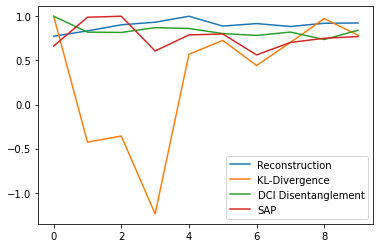

In [13]:
# For reference, given a random initialization 
plt.plot([x / max(AE_loss_tracker) for x in AE_loss_tracker], label = 'Reconstruction')
plt.plot([x / max(kld_list) for x in kld_list], label = 'KL-Divergence')
plt.plot([x / max(dci_list) for x in dci_list], label = 'DCI Disentanglement')
plt.plot([x / max(sap_list) for x in sap_list], label = 'SAP')
plt.legend(loc = 'best')
plt.show()

torch.Size([512, 2, 1, 1])


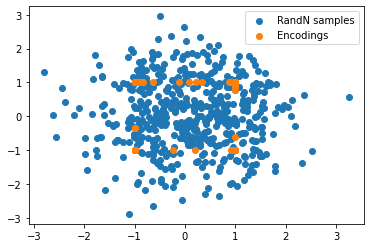

In [14]:
# Then show the latent space: do a visualization of where the training samples are encoded, and overlay
# some random normal samples. Can do PCA to get this projection and apply it to both sets
# Do a scatter plot and color them differently

# The encodings are in z-dim. We could project to 2-dim with PCA?

train_loader = torch.utils.data.DataLoader(train_dataset_normal, 
                                           batch_size=512, 
                                           drop_last = True,
                                           pin_memory = True # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
                                           #num_workers = 0
                                          )

with torch.no_grad():
    for X, code in train_loader:
        X = X.to(device)
        mini_batch = X.shape[0]
        encodings = AE.encode(X)
        print(encodings.shape)
        encodings = encodings.view(512, z_dim).cpu()
        z_ = torch.randn((512, z_dim))
        plt.scatter(z_[:,0], z_[:,1], label = 'RandN samples')
        plt.scatter(encodings[:,0], encodings[:, 1], label = 'Encodings')
        plt.legend(loc = 'best')
        plt.show()
        
        break

In [15]:
# 0 Variation Term on 9 codes:
with torch.no_grad():
    codes = get_codes(9).to(device)
    varis = torch.zeros((9, v_dim), device = device) # 'Basis' codes, the conditions under no variation
    #print(codes.shape, varis.shape)
    codes = codes.view(9, c_dim, 1, 1)
    varis = varis.view(9, v_dim, 1, 1)
    generated = .5*(AE.decode(varis, codes).cpu() + 1)
    #print(torch.min(generated), torch.max(generated))
        
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        #print(generated[i,:].shape)
        element = generated[i,:].permute(1,2,0)
        plt.imshow(element)
    plt.show()
print('Above plot should show constant _color_ on 9 random others')
print('Below plot is 9 v_samples on 1 code c')
# 9 Variations on one code:
with torch.no_grad():
    codes = torch.cat(9*[get_codes(1)]).to(device)
    #print(codes)
    #varis = torch.rand((9, v_dim), device = device) # For some random variations
    varis = torch.Tensor([x/8 for x in list(range(9))]).to(device)
    codes = codes.view(9, c_dim, 1, 1)
    varis = varis.view(9, v_dim, 1, 1)
    generated = .5*(AE.decode(varis, codes).cpu() + 1)
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        element = generated[i,:].permute(1,2,0)
        plt.imshow(element)
    plt.show()
    


NameError: name 'v_dim' is not defined

In [ ]:
from torchviz import make_dot
print(AE)
AE = AE.cpu()
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = AE(x)
arch = make_dot(out).render('attached', format = 'png')  # plot graph of variable, not of a nn.Module

In [ ]:
print(max(D_loss_tracker))
plt.plot([x/max(D_loss_tracker) for x in D_loss_tracker], label = 'D_loss_tracker')
plt.plot([x/max(G_loss_tracker) for x in G_loss_tracker], label = 'G_loss_tracker')
plt.plot([x/max(z_loss_tracker) for x in z_loss_tracker], label = 'z_loss_tracker')
plt.plot([x/max(c_loss_tracker) for x in c_loss_tracker], label = 'c_loss_tracker')
#plt.plot([x/max(test_loss_tracker) for x in test_loss_tracker], label = 'test_loss_tracker')
#plt.plot([x(max(condition_respect_tracker) for x in condition_respect_tracker], label = 'condition_respect_tracker')

plt.legend(loc = 'best')
plt.title('Check em out')
plt.show()

In [ ]:
print(train_images[0].shape)
plt.imshow(train_images[0].permute(1,2,0))
plt.show()

print('here is the first code for the above image: ')
print(train_codes[0])
first_code = train_codes[0]
print('Here is the generator making 9 versions of this image: ')

with torch.no_grad():
    vis_size = 3
    z_ = torch.rand((vis_size**2, z_dim))#.view(-1, z_dim, 1, 1)
    z_ = Variable(z_.cuda())

    code = torch.stack(vis_size**2*[first_code])

    test_images = .5*(generator.decode(z_, code)+1)
    print(torch.min(test_images), torch.max(test_images))
    #print(torch.min(test_images), torch.max(test_images))
    grid_img = torchvision.utils.make_grid(test_images, nrow = vis_size)
    plt.imshow(grid_img.permute(1,2,0).cpu().numpy())
    plt.show()

# Demonstrate Conditions

In [ ]:
#disentanglement metrics:

# set of factors of shape (n_examples, n_factors):

# set of codes of shape (n_example, n_codes)